In [18]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [15]:
np.random.seed(1)
tf.set_random_seed(1)

In [19]:
class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=300,
            memory_size=500,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))

        # consist of [target_net, evaluate_net]
        self._build_net()
        t_params = tf.get_collection('target_net_params')
        e_params = tf.get_collection('eval_net_params')
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            # tf.train.SummaryWriter soon be deprecated, use following
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []

    def _build_net(self):
        # ------------------ build evaluate_net ------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss
        with tf.variable_scope('eval_net'):
            # c_names(collections_names) are the collections to store variables
            c_names, n_l1, w_initializer, b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 10, \
                tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)  # config of layers

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_eval = tf.matmul(l1, w2) + b2

        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')    # input
        with tf.variable_scope('target_net'):
            # c_names(collections_names) are the collections to store variables
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s_, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_next = tf.matmul(l1, w2) + b2

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
            print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        q_next, q_eval = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={
                self.s_: batch_memory[:, -self.n_features:],  # fixed params
                self.s: batch_memory[:, :self.n_features],  # newest params
            })

        # change q_target w.r.t q_eval's action
        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]

        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis=1)

        """
        For example in this batch I have 2 samples and 3 actions:
        q_eval =
        [[1, 2, 3],
         [4, 5, 6]]

        q_target = q_eval =
        [[1, 2, 3],
         [4, 5, 6]]

        Then change q_target with the real q_target value w.r.t the q_eval's action.
        For example in:
            sample 0, I took action 0, and the max q_target value is -1;
            sample 1, I took action 2, and the max q_target value is -2:
        q_target =
        [[-1, 2, 3],
         [4, 5, -2]]

        So the (q_target - q_eval) becomes:
        [[(-1)-(1), 0, 0],
         [0, 0, (-2)-(6)]]

        We then backpropagate this error w.r.t the corresponding action to network,
        leave other action as error=0 cause we didn't choose it.
        """

        # train eval network
        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot_cost(self):
        import matplotlib.pyplot as plt
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()


In [5]:
import numpy as np
import time
import sys
if sys.version_info.major == 2:
    import Tkinter as tk
else:
    import tkinter as tk

UNIT = 40   # pixels
MAZE_H = 4  # grid height
MAZE_W = 4  # grid width


class Maze(tk.Tk, object):
    def __init__(self):
        super(Maze, self).__init__()
        self.action_space = ['u', 'd', 'l', 'r']
        self.n_actions = len(self.action_space)
        self.n_features = 2
        self.title('maze')
        self.geometry('{0}x{1}'.format(MAZE_W * UNIT, MAZE_H * UNIT))
        self._build_maze()

    def _build_maze(self):
        self.canvas = tk.Canvas(self, bg='white',
                           height=MAZE_H * UNIT,
                           width=MAZE_W * UNIT)

        # create grids
        for c in range(0, MAZE_W * UNIT, UNIT):
            x0, y0, x1, y1 = c, 0, c, MAZE_H * UNIT
            self.canvas.create_line(x0, y0, x1, y1)
        for r in range(0, MAZE_H * UNIT, UNIT):
            x0, y0, x1, y1 = 0, r, MAZE_W * UNIT, r
            self.canvas.create_line(x0, y0, x1, y1)

        # create origin
        origin = np.array([20, 20])

        # hell
        hell1_center = origin + np.array([UNIT * 2, UNIT])
        self.hell1 = self.canvas.create_rectangle(
            hell1_center[0] - 15, hell1_center[1] - 15,
            hell1_center[0] + 15, hell1_center[1] + 15,
            fill='black')
        # hell
        # hell2_center = origin + np.array([UNIT, UNIT * 2])
        # self.hell2 = self.canvas.create_rectangle(
        #     hell2_center[0] - 15, hell2_center[1] - 15,
        #     hell2_center[0] + 15, hell2_center[1] + 15,
        #     fill='black')

        # create oval
        oval_center = origin + UNIT * 2
        self.oval = self.canvas.create_oval(
            oval_center[0] - 15, oval_center[1] - 15,
            oval_center[0] + 15, oval_center[1] + 15,
            fill='yellow')

        # create red rect
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')

        # pack all
        self.canvas.pack()

    def reset(self):
        self.update()
        time.sleep(0.1)
        self.canvas.delete(self.rect)
        origin = np.array([20, 20])
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')
        # return observation
        return (np.array(self.canvas.coords(self.rect)[:2]) - np.array(self.canvas.coords(self.oval)[:2]))/(MAZE_H*UNIT)

    def step(self, action):
        s = self.canvas.coords(self.rect)
        base_action = np.array([0, 0])
        if action == 0:   # up
            if s[1] > UNIT:
                base_action[1] -= UNIT
        elif action == 1:   # down
            if s[1] < (MAZE_H - 1) * UNIT:
                base_action[1] += UNIT
        elif action == 2:   # right
            if s[0] < (MAZE_W - 1) * UNIT:
                base_action[0] += UNIT
        elif action == 3:   # left
            if s[0] > UNIT:
                base_action[0] -= UNIT

        self.canvas.move(self.rect, base_action[0], base_action[1])  # move agent

        next_coords = self.canvas.coords(self.rect)  # next state

        # reward function
        if next_coords == self.canvas.coords(self.oval):
            reward = 1
            done = True
        elif next_coords in [self.canvas.coords(self.hell1)]:
            reward = -1
            done = True
        else:
            reward = 0
            done = False
        s_ = (np.array(next_coords[:2]) - np.array(self.canvas.coords(self.oval)[:2]))/(MAZE_H*UNIT)
        return s_, reward, done

    def render(self):
        # time.sleep(0.01)
        self.update()

In [6]:
def run_maze():
    step = 0
    for episode in range(300):
        # initial observation
        observation = env.reset()

        while True:
            # fresh env
            env.render()

            # RL choose action based on observation
            action = RL.choose_action(observation)

            # RL take action and get next observation and reward
            observation_, reward, done = env.step(action)

            RL.store_transition(observation, action, reward, observation_)

            if (step > 200) and (step % 5 == 0):
                RL.learn()

            # swap observation
            observation = observation_

            # break while loop when end of this episode
            if done:
                break
            step += 1

    # end of game
    print('game over')
    env.destroy()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced

game over


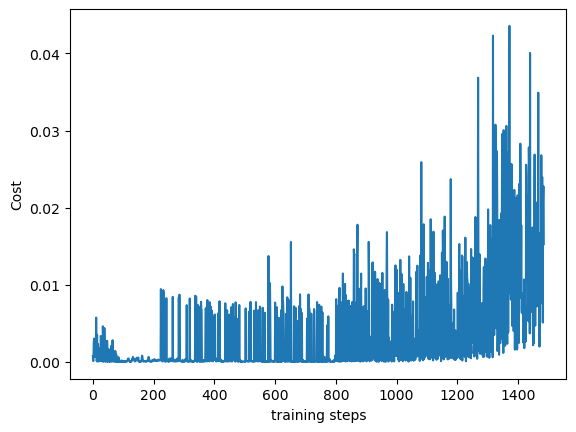

In [20]:
if __name__ == "__main__":
    # maze game
    env = Maze()
    RL = DeepQNetwork(env.n_actions, env.n_features,
                      learning_rate=0.01,
                      reward_decay=0.9,
                      e_greedy=0.9,
                      replace_target_iter=200,
                      memory_size=2000,
                      # output_graph=True
                      )
    env.after(100, run_maze)
    env.mainloop()
    RL.plot_cost()